### Using SAM Model to Extract the Main Part of the Object

In [ ]:
from segment_anything import SamPredictor, sam_model_registry
import numpy as np
from PIL import Image
import torch
from matplotlib import pyplot as plt
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
predictor = SamPredictor(sam)

##### Example Visualization

In [2]:
num_img = 53
img_path = f"IGNP/images/image_{num_img}.jpg"
img = np.array(Image.open(img_path).convert("RGB"))
input_box = np.array([100, 100, 3000, 3500])
predictor.set_image(img)

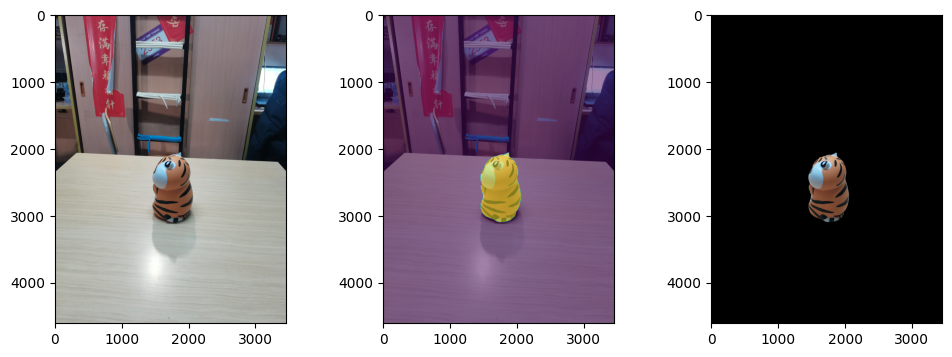

In [6]:
masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=np.array([1000, 2000, 2500, 3000]),
        multimask_output=False,
    )
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
# show the mask on the image
plt.imshow(img)
plt.imshow(masks[0][:, :, None], alpha=0.5)
plt.subplot(133)
plt.imshow(img * masks[0][:, :, None])

[1457, 2061, 2066, 3101]


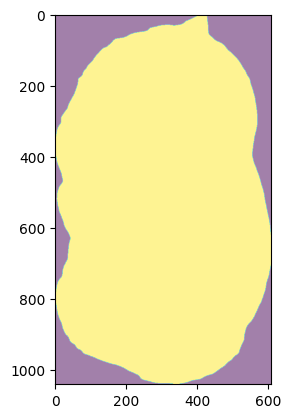

In [7]:
up, down, left, right = 0, 0, 0, 0
for i in range(masks[0].shape[0]):
  if np.sum(masks[0][i]) > 0 and up == 0:
    up = i
  if (np.sum(masks[0][i]) < 1) and (up > 0) and (i > up + 100):
    down = i
    break
for j in range(masks[0].shape[1]):
  if np.sum(masks[0][:, j]) > 0 and left == 0:
    left = j
  if (np.sum(masks[0][:, j]) < 1) and left > 0 and j > left + 100:
    right = j
    break
print([left, up, right, down])
# [left, up, right, down]
plt.imshow(masks[0][up:down, left:right, None], alpha=0.5)

##### Using Pre-estimated BBox (by myself) to Make the Prediction Better

In [1]:
import json
with open("coordinate.json", "r") as f:
  coordinate = json.load(f)

In [10]:
import imageio
from tqdm import tqdm
import numpy as np
from PIL import Image
for i in tqdm(range(134)):
    if i < 10:
        num = "0" + str(i)
    else:
        num = str(i)
    img_path = f"IGNP/images/image_{i}.jpg"
    img = np.array(Image.open(img_path).convert("RGB"))
    # plt.imshow(img)
    predictor.set_image(img)
    input_box = np.array(coordinate[i])
    # [left, up, right, down]
    input_box[0] = input_box[0] - 50
    input_box[1] = input_box[1] - 50
    input_box[2] = input_box[2] + 50
    input_box[3] = input_box[3] + 50
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )
    all_img = np.stack([img[:,:,0], img[:,:,1], img[:,:,2], (masks * 255).reshape(4608, 3456)], axis=2)
    # save to png using imageio
    imageio.imwrite(f"IGNP/images_processed/0{num}.png", all_img.astype(np.uint8))
    center = [int((input_box[0] + input_box[2]) / 2), int((input_box[1] + input_box[3]) / 2)]
    square_side = 1200
    square_left, square_up = center[0] - 600, center[1] - 600
    # crop to 1200 * 1200
    
    square_img = img[square_up:square_up + square_side, square_left:square_left + square_side, :]
    square_mask = (masks * 255).reshape(4608, 3456)[square_up:square_up + square_side, square_left:square_left + square_side]
    # save to png using imageio
    new_mask = square_mask // 255
    all_img = np.stack([square_img[:,:,0] * new_mask, square_img[:,:,1] * new_mask, square_img[:,:,2] * new_mask, square_mask], axis=2)
    imageio.imwrite(f"IGNP/images_processed/0{num}.png", all_img.astype(np.uint8))

  0%|          | 0/134 [00:00<?, ?it/s]

100%|██████████| 134/134 [19:03<00:00,  8.53s/it]
